In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
columns_labels = [ 'Device ID', 'accelerometer x', 'accelerometer y', 'accelerometer z',
    'gyroscope x', 'gyroscope y', 'gyroscope z', 'magnetometer x', 'magnetometer y', 'magnetometer z',
    'Timestamp', 'Activity Label']

activities = ['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk']

### 2. Read Files

In [62]:
def readFiles(ID, devi = 2):
    file = "part" + str(ID)
    pasta = "dataset\part" + str(ID)

    dev = [0]*5

    for i in range(5):
        f = file + "dev" + str(devi) + ".csv"
        dir = os.path.join(pasta, f)
        dev[i] = np.genfromtxt(dir, delimiter=',')

    dFrame = pd.DataFrame(np.concatenate(dev), columns=columns_labels)

    return [np.concatenate(dev), dFrame]

[data, dataFrame] = readFiles(0)

### 3. Módulo

In [66]:
def modulo(dFrame):
    acc = []
    gir = []
    mag = []

    for i in range(16):
        activity = dFrame.loc[dFrame['Activity Label'] == i+1]
        acc += [pd.DataFrame(np.sqrt(activity['accelerometer x']**2 + activity['accelerometer y']**2 + activity['accelerometer x']**2), columns=[i+1])]

        activity = dFrame.loc[dFrame['Activity Label'] == i+1]
        gir += [pd.DataFrame(np.sqrt(activity['gyroscope x']**2 + activity['gyroscope y']**2 + activity['gyroscope x']**2), columns=[i+1])]

        activity = dFrame.loc[dFrame['Activity Label'] == i+1]
        mag += [pd.DataFrame(np.sqrt(activity['magnetometer x']**2 + activity['magnetometer y']**2 + activity['magnetometer x']**2), columns=[i+1])]

    acc = pd.concat(acc)
    gir = pd.concat(gir)
    mag = pd.concat(mag)

    return [acc, gir, mag]

[acc, gir, mag] = modulo(dataFrame)

[                1
 0       10.009717
 1        9.964901
 2        9.967331
 3        9.875179
 4        9.807041
 ...           ...
 264315   9.674424
 264316   9.617336
 264317   9.640220
 264318   9.667799
 264319   9.666435
 
 [55060 rows x 1 columns],
                2
 2944    2.480837
 2945    2.519873
 2946    2.492284
 2947    2.471080
 2948    2.462440
 ...          ...
 220155  2.526122
 220156  2.175920
 220157  2.054129
 220158  2.786818
 220159  2.810159
 
 [28800 rows x 1 columns],
                3
 10624   2.235667
 10625   2.195179
 10626   2.244788
 10627   2.288492
 10628   2.284629
 ...          ...
 227835  2.408986
 227836  2.415929
 227837  2.379855
 227838  2.478384
 227839  2.297552
 
 [28800 rows x 1 columns],
                 4
 18175   11.507667
 18176   13.288239
 18177   14.557163
 18178   13.635230
 18179   11.456517
 ...           ...
 254075   9.748324
 254076   9.781426
 254077   9.795780
 254078   9.756348
 254079   9.817717
 
 [43530 rows x 1 column

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10.009717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.964901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.967331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.875179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.807041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.432477
258427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.094163
258428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.724088
258429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.509850


### 3.1 Boxplot dos módulos

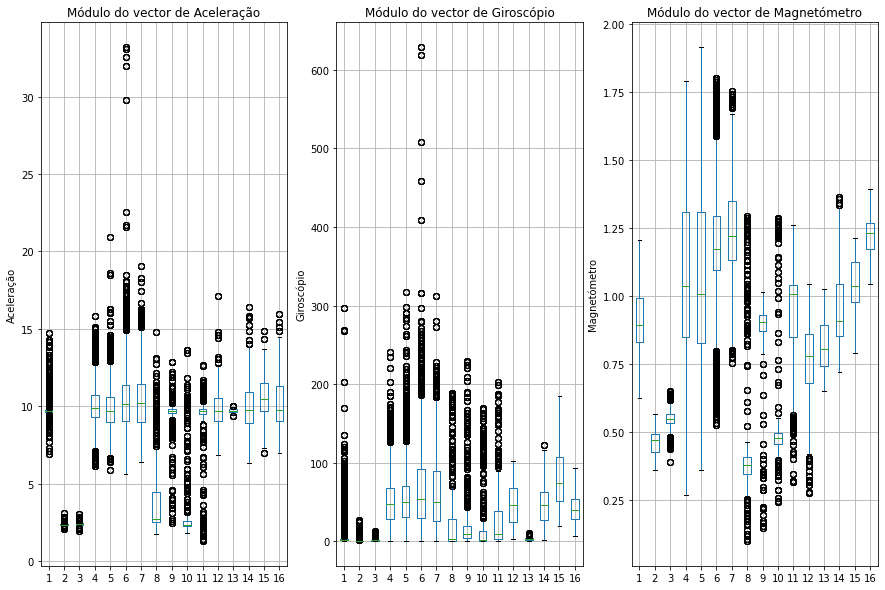

In [64]:
def boxplot(acc, gir, mag):

    plt.figure(figsize=(15,10))
    
    plt.subplot(1,3,1)
    plt.title("Módulo do vector de Aceleração")
    plt.ylabel("Aceleração")
    acc.boxplot()

    plt.subplot(1,3,2)
    plt.title("Módulo do vector de Giroscópio")
    plt.ylabel("Giroscópio")
    gir.boxplot()

    plt.subplot(1,3,3)
    plt.title("Módulo do vector de Magnetómetro")
    plt.ylabel("Magnetómetro")
    mag.boxplot()

    plt.savefig("modulos")

boxplot(acc, gir, mag)